<a href="https://colab.research.google.com/github/Ricardomanuel1/Maestria_Ciencia_de_Datos/blob/main/MACHINE%20LEARNING%20Y%20DEEP%20LEARNING/1_GPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Entrenamiento modelo GPT**

In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import json
import re
import string
from IPython.display import display, HTML

import tensorflow as tf
from tensorflow.keras import layers, models, losses, callbacks

Parámetros

In [ ]:
VOCAB_SIZE = 10000
MAX_LEN = 80
EMBEDDING_DIM = 256
KEY_DIM = 256
N_HEADS = 2
FEED_FORWARD_DIM = 256
VALIDATION_SPLIT = 0.2
SEED = 42
LOAD_MODEL = False
BATCH_SIZE = 32
EPOCHS = 5

##**1. Carga de Datos**

In [ ]:
url = "https://raw.githubusercontent.com/xsarinix/py_and_wine/master/winemag-data-130k-v2.json"

In [ ]:
import urllib.request, json
with urllib.request.urlopen(url) as url:
    wine_data = json.load(url)


In [ ]:
# Carga de archivo
#with open("file") as json_data:
#    wine_data = json.load(json_data)

In [ ]:
wine_data[10]

{'points': '87',
 'title': 'Kirkland Signature 2011 Mountain Cuvée Cabernet Sauvignon (Napa Valley)',
 'description': 'Soft, supple plum envelopes an oaky structure in this Cabernet, supported by 15% Merlot. Coffee and chocolate complete the picture, finishing strong at the end, resulting in a value-priced wine of attractive flavor and immediate accessibility.',
 'taster_name': 'Virginie Boone',
 'taster_twitter_handle': '@vboone',
 'price': 19,
 'designation': 'Mountain Cuvée',
 'variety': 'Cabernet Sauvignon',
 'region_1': 'Napa Valley',
 'region_2': 'Napa',
 'province': 'California',
 'country': 'US',
 'winery': 'Kirkland Signature'}

In [ ]:
# Filter the dataset
filtered_data = [
    "wine review : "
    + x["country"]
    + " : "
    + x["province"]
    + " : "
    + x["variety"]
    + " : "
    + x["description"]
    for x in wine_data
    if x["country"] is not None
    and x["province"] is not None
    and x["variety"] is not None
    and x["description"] is not None
]

In [ ]:
# Count the recipes
n_wines = len(filtered_data)
print(f"{n_wines} recipes loaded")

129907 recipes loaded


In [ ]:
example = filtered_data[25]
print(example)

wine review : US : California : Pinot Noir : Oak and earth intermingle around robust aromas of wet forest floor in this vineyard-designated Pinot that hails from a high-elevation site. Small in production, it offers intense, full-bodied raspberry and blackberry steeped in smoky spice and smooth texture.


##**2. Tokenizar los datos**

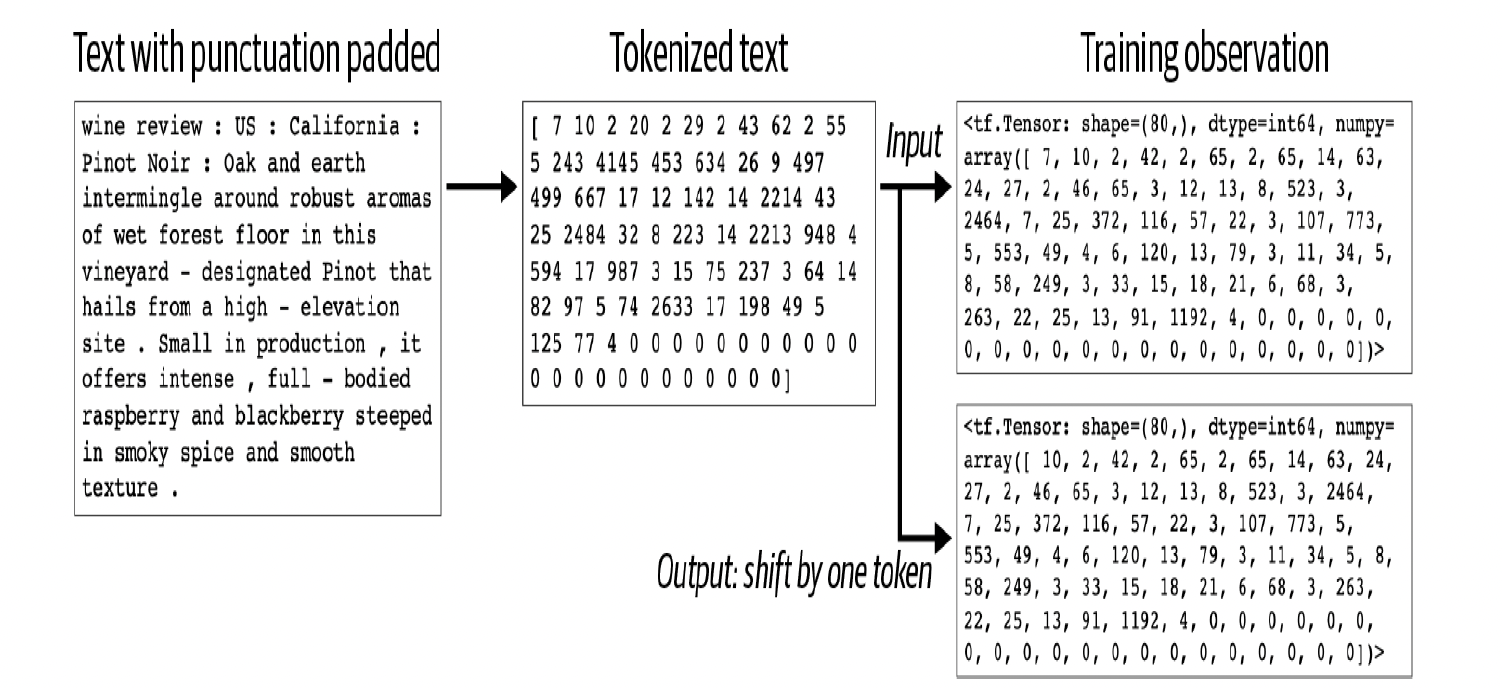

In [ ]:
# Pad the punctuation, to treat them as separate 'words'
def pad_punctuation(s):
    s = re.sub(f"([{string.punctuation}, '\n'])", r" \1 ", s)
    s = re.sub(" +", " ", s)
    return s


text_data = [pad_punctuation(x) for x in filtered_data]

In [ ]:
# Display an example of a recipe
example_data = text_data[25]
example_data

'wine review : US : California : Pinot Noir : Oak and earth intermingle around robust aromas of wet forest floor in this vineyard - designated Pinot that hails from a high - elevation site . Small in production , it offers intense , full - bodied raspberry and blackberry steeped in smoky spice and smooth texture . '

In [ ]:
# Convert to a Tensorflow Dataset
text_ds = (
    tf.data.Dataset.from_tensor_slices(text_data)
    .batch(BATCH_SIZE)
    .shuffle(1000)
)

In [ ]:
# Create a vectorisation layer
vectorize_layer = layers.TextVectorization(
    standardize="lower",
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=MAX_LEN + 1,
)

In [ ]:
# Adapt the layer to the training set
vectorize_layer.adapt(text_ds)
vocab = vectorize_layer.get_vocabulary()

In [ ]:
# Display some token:word mappings
for i, word in enumerate(vocab[:10]):
    print(f"{i}: {word}")

0: 
1: [UNK]
2: :
3: ,
4: .
5: and
6: the
7: wine
8: a
9: of


In [ ]:
# Display the same example converted to ints
example_tokenised = vectorize_layer(example_data)
print(example_tokenised.numpy())

[   7   10    2   20    2   29    2   43   62    2   55    5  243 4145
  453  634   26    9  497  499  667   17   12  142   14 2214   43   25
 2484   32    8  223   14 2213  948    4  594   17  987    3   15   75
  237    3   64   14   82   97    5   74 2633   17  198   49    5  125
   77    4    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]


##**3.Creación del conjunto de entrenamiento**

In [ ]:
# Create the training set of recipes and the same text shifted by one word
def prepare_inputs(text):
    text = tf.expand_dims(text, -1)
    tokenized_sentences = vectorize_layer(text)
    x = tokenized_sentences[:, :-1]
    y = tokenized_sentences[:, 1:]
    return x, y


train_ds = text_ds.map(prepare_inputs)

In [ ]:
example_input_output = train_ds.take(1).get_single_element()

In [ ]:
# Example Input
example_input_output[0][0]

<tf.Tensor: shape=(80,), dtype=int64, numpy=
array([   7,   10,    2,  152,    2,  723,    2,  230,   24,    2,    6,
          1, 1540, 9957,  337,   41,  515,    8,  697,    3,  166,    5,
        310,    7,    4,   15,   13,   57,    3, 1922,   47,   74,    5,
         78,   67,    5, 2667,   16,    4,    6,   30,   25,   18,   21,
         79,   13,  334,   19, 1525,   11,    6,   38,  361,   80,    6,
         34,    5,  330,    9,  126,   16,  347, 1171, 1114,  168,    4,
         35,   32,  291,    4,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0])>

In [ ]:
# Example Output (shifted by one token)
example_input_output[1][0]

<tf.Tensor: shape=(80,), dtype=int64, numpy=
array([  10,    2,  152,    2,  723,    2,  230,   24,    2,    6,    1,
       1540, 9957,  337,   41,  515,    8,  697,    3,  166,    5,  310,
          7,    4,   15,   13,   57,    3, 1922,   47,   74,    5,   78,
         67,    5, 2667,   16,    4,    6,   30,   25,   18,   21,   79,
         13,  334,   19, 1525,   11,    6,   38,  361,   80,    6,   34,
          5,  330,    9,  126,   16,  347, 1171, 1114,  168,    4,   35,
         32,  291,    4,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0])>

##**4.Crear la función de causal attention mask**

In [ ]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)


np.transpose(causal_attention_mask(1, 10, 10, dtype=tf.int32)[0])

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int32)

##**5. Crear una capa de bloque Transformer**

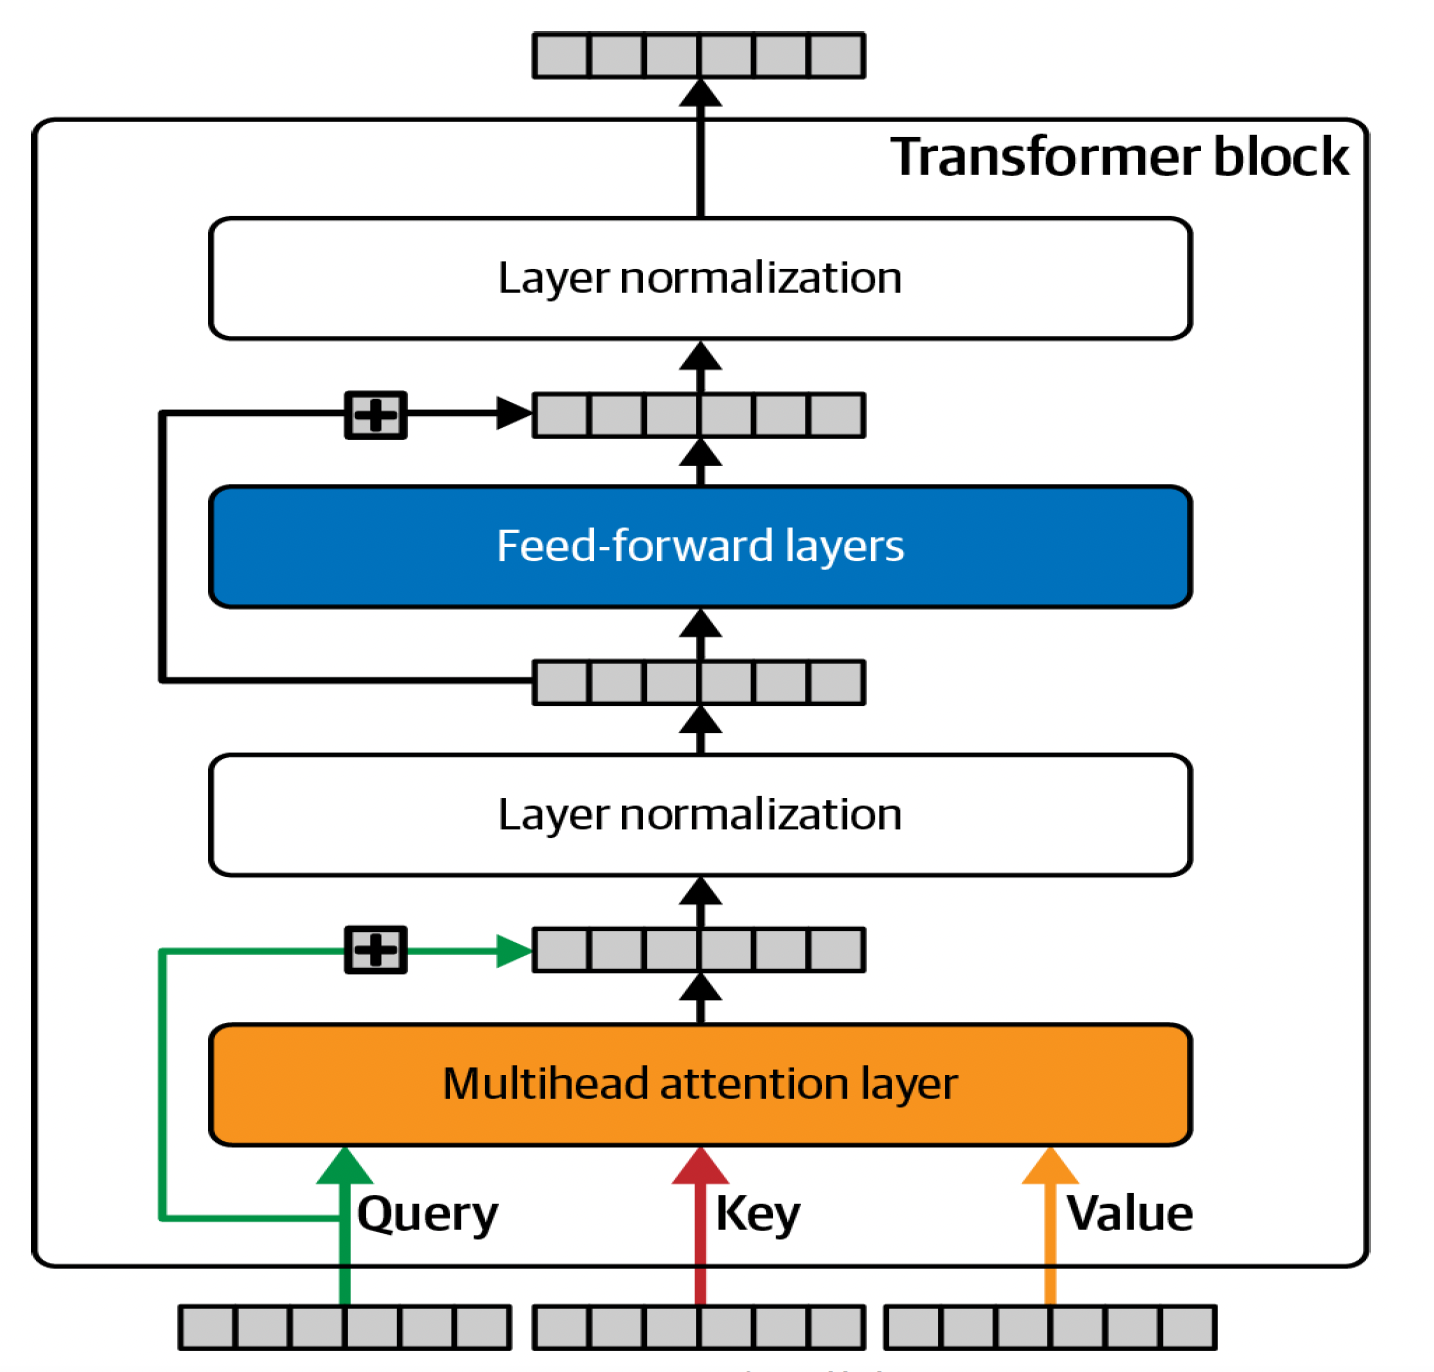

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, num_heads, key_dim, embed_dim, ff_dim, dropout_rate=0.1):
        super(TransformerBlock, self).__init__()
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        self.attn = layers.MultiHeadAttention(
            num_heads, key_dim, output_shape=embed_dim
        )
        self.dropout_1 = layers.Dropout(self.dropout_rate)
        self.ln_1 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn_1 = layers.Dense(self.ff_dim, activation="relu")
        self.ffn_2 = layers.Dense(self.embed_dim)
        self.dropout_2 = layers.Dropout(self.dropout_rate)
        self.ln_2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(
            batch_size, seq_len, seq_len, tf.bool
        )
        attention_output, attention_scores = self.attn(
            inputs,
            inputs,
            attention_mask=causal_mask,
            return_attention_scores=True,
        )
        attention_output = self.dropout_1(attention_output)
        out1 = self.ln_1(inputs + attention_output)
        ffn_1 = self.ffn_1(out1)
        ffn_2 = self.ffn_2(ffn_1)
        ffn_output = self.dropout_2(ffn_2)
        return (self.ln_2(out1 + ffn_output), attention_scores)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "key_dim": self.key_dim,
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "ff_dim": self.ff_dim,
                "dropout_rate": self.dropout_rate,
            }
        )
        return config

- Las subcapas que componen la capa del TransformerBlock se definen dentro de la función de inicialización.
- El causal mask es creado para ocultar keys futuras de la query.
- La capa de multihead attention es creada, con las attention masks especificadas.
- La primera capa adición y normalización.
- Las capas  feed-forward.
- La segunda capa de adición y normalización.

##**6. Crear el embedding de posición y token**

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, max_len, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.max_len = max_len
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.pos_emb = layers.Embedding(input_dim=max_len, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "max_len": self.max_len,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

- Los tokens son codificados (embedded) usando an capa de Embedding.
- Las posiciones de los tokens también son codificadas usando capa de Embedding.
- La salida de la capa es la suma de embeddings de token y de posición.

##**7. Crear el modelo Transformer**

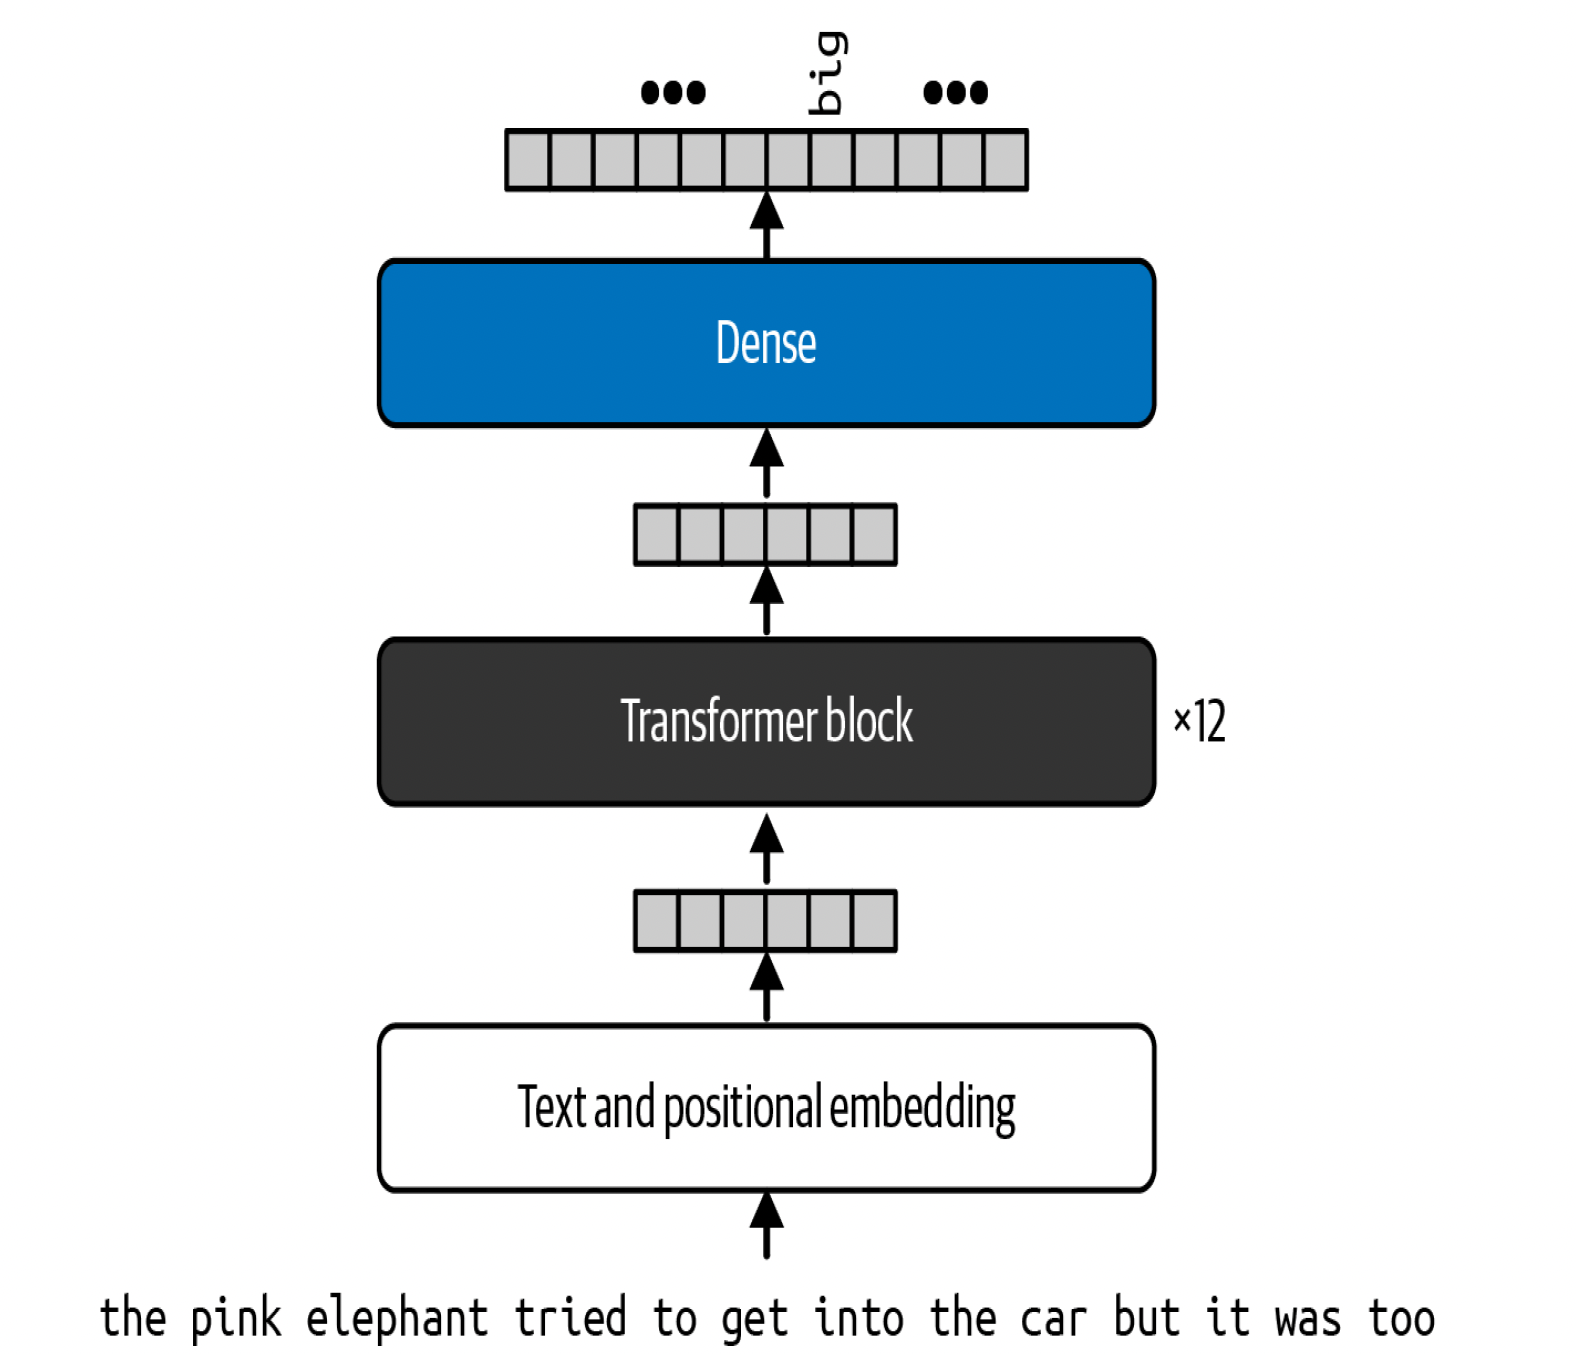

In [ ]:
inputs = layers.Input(shape=(None,), dtype=tf.int32)
x = TokenAndPositionEmbedding(MAX_LEN, VOCAB_SIZE, EMBEDDING_DIM)(inputs)
x, attention_scores = TransformerBlock(
    N_HEADS, KEY_DIM, EMBEDDING_DIM, FEED_FORWARD_DIM
)(x)
outputs = layers.Dense(VOCAB_SIZE, activation="softmax")(x)
gpt = models.Model(inputs=inputs, outputs=[outputs, attention_scores])
gpt.compile("adam", loss=[losses.SparseCategoricalCrossentropy(), None])

- La entrada es padded (con ceros).
- El texto es codificado usando una capa de TokenAndPositionEmbedding.
- La codificación es pasada por el TransformerBlock.
- La salida transformada pasa por una capa Densa con activación softmax para predecir una distribución sobre la palabra subsecuente
- EL modelo tima una secuencia de tokens de palabras como entrada y devuelve la distribución de palabras subsecuente.
- La salida del bloque Transformer es también retornada para inspeccionar como se lleva a cabo la attention.
- El modelo se compila con loss SparseCategoricalCrossentropy sobre la distribución de palabras predicha.

In [ ]:
gpt.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 token_and_position_embeddi  (None, None, 256)         2580480   
 ng (TokenAndPositionEmbedd                                      
 ing)                                                            
                                                                 
 transformer_block (Transfo  ((None, None, 256),       658688    
 rmerBlock)                   (None, 2, None, None))             
                                                                 
 dense_2 (Dense)             (None, None, 10000)       2570000   
                                                                 
Total params: 5809168 (22.16 MB)
Trainable params: 5809168 (22.16 MB)
Non-trainable params: 0 (0.00 Byte)
_____________________

In [ ]:
if LOAD_MODEL:
    # model.load_weights('./models/model')
    gpt = models.load_model("./models/gpt", compile=True)

##**8. Entrenar Transformer**

Se genera texto nuevo aplicando el siguiente proceso:

- Alimente la red con una secuencia existente de palabras y pida para predecir la siguiente palabra.
- Agregue esta palabra a la secuencia existente y repita.

La red generará un conjunto de probabilidades para cada palabra de la que podamos tomar muestras, por lo que la generación de texto es estocástica, en lugar de determinista.


- Temperatura 0: se escoge el token con mayor probabilidad  
- Temperatura 1: se basa en muestreo (más imprecisa)

In [ ]:
# Create a TextGenerator checkpoint
class TextGenerator(callbacks.Callback):
    def __init__(self, index_to_word, top_k=10):
        self.index_to_word = index_to_word
        self.word_to_index = {
            word: index for index, word in enumerate(index_to_word)
        }

    def sample_from(self, probs, temperature):
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs), probs

    def generate(self, start_prompt, max_tokens, temperature):
        start_tokens = [
            self.word_to_index.get(x, 1) for x in start_prompt.split()
        ]
        sample_token = None
        info = []
        while len(start_tokens) < max_tokens and sample_token != 0:
            x = np.array([start_tokens])
            y, att = self.model.predict(x, verbose=0)
            sample_token, probs = self.sample_from(y[0][-1], temperature)
            info.append(
                {
                    "prompt": start_prompt,
                    "word_probs": probs,
                    "atts": att[0, :, -1, :],
                }
            )
            start_tokens.append(sample_token)
            start_prompt = start_prompt + " " + self.index_to_word[sample_token]
        print(f"\ngenerated text:\n{start_prompt}\n")
        return info

    def on_epoch_end(self, epoch, logs=None):
        self.generate("wine review", max_tokens=80, temperature=1.0)

In [ ]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

In [ ]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

# Tokenize starting prompt
text_generator = TextGenerator(vocab)

In [ ]:
gpt.fit(
    train_ds,
    epochs=EPOCHS,
    callbacks=[model_checkpoint_callback, tensorboard_callback, text_generator],
)

Epoch 1/5
4060/4060 [==============================] - ETA: 0s - loss: 2.2520 - dense_2_loss: 2.2520
generated text:
wine review : us : california : syrah : dark in color and meaty aromas of tar , teriyaki and rhubarb give way to an enormously rich , fruity syrah . it ' s simple in blackberry and cherry , the tannins are powerfully . drink 2015–2025 . 

4060/4060 [==============================] - 149s 35ms/step - loss: 2.2520 - dense_2_loss: 2.2520
Epoch 2/5
4060/4060 [==============================] - ETA: 0s - loss: 1.9600 - dense_2_loss: 1.9600
generated text:
wine review : us : new york : bordeaux - style red blend : juicy cherry and berry flavors are strikingly acidic and leaves on this ripe , elegantly composed bordeaux - style wine . it charms with an abundance of ripe red berries and fresh acidity . the [UNK] is just about sweet simplicity , but it will make for a [UNK] anytime bottle . screwcap . 

4060/4060 [==============================] - 117s 29ms/step - loss: 1.9600 - d

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
#url ="/content/drive/My Drive/Colab Notebooks/"
url ="/content/drive/My Drive/Colab Notebooks/MaestriaCienciaDatosV1/MachineLearningAplicado/Sesion14/"

In [ ]:
# Save the final model
#gpt.save("./models/gpt")
gpt.save(url+"gpt")

##**9. Generar texto usando el Transformer**

In [ ]:
def print_probs(info, vocab, top_k=5):
    for i in info:
        highlighted_text = []
        for word, att_score in zip(
            i["prompt"].split(), np.mean(i["atts"], axis=0)
        ):
            highlighted_text.append(
                '<span style="background-color:rgba(135,206,250,'
                + str(att_score / max(np.mean(i["atts"], axis=0)))
                + ');">'
                + word
                + "</span>"
            )
        highlighted_text = " ".join(highlighted_text)
        display(HTML(highlighted_text))

        word_probs = i["word_probs"]
        p_sorted = np.sort(word_probs)[::-1][:top_k]
        i_sorted = np.argsort(word_probs)[::-1][:top_k]
        for p, i in zip(p_sorted, i_sorted):
            print(f"{vocab[i]}:   \t{np.round(100*p,2)}%")
        print("--------\n")

In [ ]:
info = text_generator.generate(
    "wine review : us", max_tokens=80, temperature=1.0
)


generated text:
wine review : us : california : cabernet franc : a lovely cabernet sauvignon - driven version of this should please the variety from this appellation . it offers black cherry , wet brick and layered with the minerality holding for its texture is creamy and deceptively balanced in tannin and mellowed slightly dull finish , accented by charred oak . [UNK] . 



In [ ]:
info = text_generator.generate(
    "wine review : italy", max_tokens=80, temperature=0.5
)


generated text:
wine review : italy : tuscany : sangiovese grosso : this brunello opens with a bold , inky appearance and loads of sweet fruit aromas that are backed by loads of spice , leather and smoked bacon . the wine is a touch of dark chocolate and spice . 



In [ ]:
info = text_generator.generate(
    "wine review : germany", max_tokens=80, temperature=0.5
)
print_probs(info, vocab)


generated text:
wine review : germany : mosel : riesling : dusty mineral tones of pollen and saffron lend savoriness to this sunny , sunny riesling . it ' s juicy and juicy , with flavors of yellow peach and grapefruit , lemon and lime . it ' s a delicate , filigreed mouthfeel and a long , mouthwatering finish . 



::   	100.0%
grosso:   	0.0%
-:   	0.0%
blend:   	0.0%
zealand:   	0.0%
--------



mosel:   	85.88%
rheinhessen:   	5.97%
rheingau:   	4.0%
pfalz:   	3.61%
nahe:   	0.34%
--------



::   	94.81%
-:   	5.19%
grosso:   	0.0%
[UNK]:   	0.0%
and:   	0.0%
--------



riesling:   	100.0%
pinot:   	0.0%
mosel:   	0.0%
[UNK]:   	0.0%
white:   	0.0%
--------



::   	100.0%
-:   	0.0%
grosso:   	0.0%
blanc:   	0.0%
blend:   	0.0%
--------



a:   	26.52%
dusty:   	13.78%
while:   	12.01%
the:   	4.73%
this:   	4.44%
--------



mineral:   	98.29%
minerals:   	1.25%
pollen:   	0.17%
saffron:   	0.14%
slate:   	0.07%
--------



tones:   	89.87%
notes:   	6.83%
and:   	2.02%
complexities:   	1.14%
,:   	0.1%
--------



of:   	96.99%
accent:   	1.06%
collide:   	0.67%
lend:   	0.41%
in:   	0.13%
--------



saffron:   	41.16%
slate:   	32.94%
pollen:   	5.97%
stone:   	4.9%
crushed:   	2.93%
--------



and:   	97.1%
,:   	2.9%
spice:   	0.0%
throughout:   	0.0%
lend:   	0.0%
--------



saffron:   	71.52%
mineral:   	16.14%
slate:   	3.71%
dusty:   	3.06%
crushed:   	1.6%
--------



lend:   	95.79%
juxtapose:   	2.89%
add:   	0.51%
accent:   	0.37%
are:   	0.12%
--------



complexity:   	35.27%
a:   	27.4%
nuance:   	16.29%
savoriness:   	6.49%
savory:   	3.57%
--------



to:   	100.0%
and:   	0.0%
in:   	0.0%
of:   	0.0%
on:   	0.0%
--------



this:   	83.94%
fresh:   	11.01%
the:   	1.35%
pristine:   	1.27%
bright:   	0.63%
--------



dry:   	20.56%
intensely:   	13.66%
off:   	6.01%
sunny:   	5.2%
fresh:   	4.79%
--------



,:   	90.49%
spätlese:   	4.88%
tangerine:   	1.85%
yet:   	0.6%
riesling:   	0.41%
--------



sunny:   	42.48%
juicy:   	33.97%
off:   	5.91%
peachy:   	2.42%
full:   	2.29%
--------



,:   	32.26%
spätlese:   	28.64%
tangerine:   	26.93%
peach:   	3.29%
riesling:   	2.76%
--------



.:   	99.14%
to:   	0.41%
,:   	0.15%
that:   	0.12%
peach:   	0.08%
--------



it:   	52.94%
juicy:   	16.37%
the:   	12.25%
sunny:   	11.24%
dry:   	1.18%
--------



':   	99.99%
is:   	0.0%
finishes:   	0.0%
balances:   	0.0%
has:   	0.0%
--------



s:   	100.0%
ll:   	0.0%
[UNK]:   	0.0%
off:   	0.0%
sunny:   	0.0%
--------



juicy:   	51.08%
lusciously:   	10.41%
a:   	5.67%
dry:   	4.26%
dancingly:   	3.98%
--------



and:   	57.82%
in:   	14.46%
,:   	14.17%
on:   	8.17%
with:   	3.81%
--------



juicy:   	56.88%
fruity:   	16.32%
sweet:   	11.43%
fresh:   	6.98%
forward:   	0.95%
--------



,:   	61.64%
in:   	19.78%
on:   	11.1%
with:   	5.17%
yet:   	1.78%
--------



with:   	92.31%
yet:   	5.04%
but:   	1.29%
it:   	0.39%
boasting:   	0.25%
--------



a:   	48.52%
juicy:   	10.92%
tangerine:   	6.08%
loads:   	4.7%
yellow:   	2.71%
--------



of:   	100.0%
that:   	0.0%
ranging:   	0.0%
suggesting:   	0.0%
and:   	0.0%
--------



tangerine:   	37.09%
peach:   	19.84%
yellow:   	19.44%
lime:   	4.75%
apple:   	3.77%
--------



peach:   	89.23%
apple:   	4.92%
peaches:   	4.65%
cherry:   	0.44%
grapefruit:   	0.24%
--------



and:   	69.89%
,:   	30.08%
nectar:   	0.01%
blossom:   	0.01%
that:   	0.0%
--------



tangerine:   	58.86%
apple:   	8.25%
melon:   	7.74%
apricot:   	5.18%
pear:   	3.44%
--------



,:   	68.23%
.:   	26.72%
that:   	3.08%
on:   	0.8%
with:   	0.32%
--------



with:   	50.97%
yet:   	19.12%
but:   	9.41%
finishing:   	6.96%
tangerine:   	5.16%
--------



and:   	83.29%
-:   	15.38%
,:   	0.7%
peel:   	0.17%
tea:   	0.12%
--------



tangerine:   	50.55%
lime:   	47.32%
apple:   	0.69%
pineapple:   	0.39%
grapefruit:   	0.29%
--------



.:   	60.01%
-:   	20.21%
,:   	8.71%
acidity:   	3.4%
flavors:   	2.08%
--------



it:   	65.89%
the:   	29.54%
a:   	1.29%
zesty:   	0.86%
crisp:   	0.56%
--------



':   	97.29%
finishes:   	2.7%
is:   	0.0%
drinks:   	0.0%
should:   	0.0%
--------



s:   	100.0%
ll:   	0.0%
[UNK]:   	0.0%
-:   	0.0%
off:   	0.0%
--------



a:   	73.94%
juicy:   	2.73%
breathlessly:   	2.06%
dry:   	1.57%
satisfyingly:   	1.56%
--------



shade:   	27.34%
bit:   	10.79%
deeply:   	9.75%
delicate:   	7.93%
steely:   	3.05%
--------



,:   	68.57%
yet:   	25.46%
wine:   	4.18%
but:   	1.0%
and:   	0.53%
--------



filigreed:   	23.55%
yet:   	14.33%
spry:   	5.9%
thirst:   	4.29%
penetrating:   	4.01%
--------



texture:   	38.26%
mouthfeel:   	33.8%
sweetness:   	9.65%
yet:   	7.97%
structure:   	5.25%
--------



is:   	34.85%
and:   	23.89%
,:   	22.49%
with:   	10.14%
.:   	2.47%
--------



a:   	66.29%
finishes:   	15.8%
finishing:   	6.06%
long:   	4.8%
lingering:   	1.74%
--------



long:   	90.46%
lingering:   	5.38%
finishing:   	0.81%
steely:   	0.52%
bristle:   	0.32%
--------



,:   	89.12%
finish:   	10.78%
-:   	0.07%
time:   	0.01%
long:   	0.0%
--------



lingering:   	65.91%
mouthwatering:   	11.51%
meandering:   	5.84%
steely:   	5.77%
mineral:   	2.31%
--------



finish:   	100.0%
,:   	0.0%
fade:   	0.0%
acidity:   	0.0%
wine:   	0.0%
--------



.:   	99.87%
that:   	0.11%
with:   	0.0%
,:   	0.0%
of:   	0.0%
--------



:   	94.13%
drink:   	5.64%
it:   	0.15%
a:   	0.03%
enjoy:   	0.02%
--------

